### High Dynamic Range (HDR)
Learn how to merge exposure sequence and process high dynamic range images.

#### Goal
In this chapter, we will

Learn how to generate and display HDR image from an exposure sequence.
Use exposure fusion to merge an exposure sequence.

#### Theory
하이 다이나믹 레인지 이미징 (HDRI 또는 ​​HDR)은 표준 디지털 이미징 또는 사진 기술로 가능한 것보다 더 넓은 동적 범위의 광도를 재현하기 위해 이미징 및 사진 촬영에 사용되는 기술입니다. 사람의 시선은 다양한 조명 조건에 맞출 수 있지만 대부분의 이미징 장치는 채널당 8 비트를 사용하므로 256 단계로 제한됩니다. 현실 세계의 사진을 찍을 때 밝은 영역이 과다 노출 될 수 있지만 어두운 영역은 노출 부족이 될 수 있으므로 단일 노출을 사용하여 모든 세부 정보를 캡처 할 수는 없습니다. HDR 이미징은 채널 당 8 비트 이상 (일반적으로 32 비트 부동 소수점 값)을 사용하는 이미지에서 작동하므로 훨씬 더 넓은 동적 범위가 허용됩니다.

HDR 이미지를 얻는 방법에는 여러 가지가 있지만 가장 일반적인 방법은 다양한 노출 값으로 촬영 한 장면의 사진을 사용하는 것입니다. 이러한 노출을 결합하려면 카메라의 응답 기능을 알고 유용성을 평가하는 알고리즘이 있어야합니다. HDR 이미지가 병합 된 후 일반 디스플레이에서 보려면 HDR 이미지를 다시 8 비트로 변환해야 합니다. 이 프로세스를 tonemapping이라고합니다. 노출이 다른 이미지를 등록하고 정렬해야하기 때문에 장면이나 카메라의 물체가 장면 사이를 이동할 때 추가적인 복잡성이 발생합니다.

이 튜토리얼에서는 노출 시퀀스에서 HDR 이미지를 생성하고 표시하는 두가지 알고리즘 (Debevec, Robertson)을 보여주고 낮은 동적 범위 이미지를 생성하고 노출 시간 데이터를 필요로하지 않는 노출 융합(Mertens)이라는 대안 방법을 시연합니다. 또한, 우리는 많은 컴퓨터 비전 알고리즘에 큰 가치가 있는 카메라 응답 함수 (CRF)를 추정합니다. HDR 파이프 라인의 각 단계는 서로 다른 알고리즘과 매개 변수를 사용하여 구현 될 수 있으므로 참조 설명서를 보고 모두 참조하십시오.

#### Exposure sequence HDR
이 튜토리얼에서는 노출 시간이 15, 2.5, 1/4, 1/30 초인 4 개의 노출 이미지가 있는 다음 장면을 살펴 보겠습니다. ( [Wikipedia](https://en.wikipedia.org/wiki/High-dynamic-range_imaging) 에서 이미지를 다운로드 할 수 있습니다 )

![](exposures.jpg)

##### 1. Loading exposure images into a list
첫 번째 단계는 모든 이미지를 목록에로드하는 것입니다. 또한 일반 HDR 알고리즘의 노출 시간도 필요합니다. 이미지는 1 채널 또는 3 채널 8 비트 (np.uint8)이어야 하고 노출 시간은 float32 및 초가되어야 하므로 데이터 유형에 주의 하십시오.


In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# Loading exposure images into a list
img_fn         = ["img0.jpg", "img1.jpg", "img2.jpg", "img3.jpg"]
img_list       = [cv.imread(fn) for fn in img_fn]
exposure_times = np.array([0.0333, 0.25, 2.5, 15.0], dtype = np.float32)

##### 2. Merge exposures into HDR image
이 단계에서는 노출 시퀀스를 하나의 HDR 이미지로 병합하여 OpenCV에서 가능한 두 가지 가능성을 보여줍니다. 첫 번째 방법은 Debevec이고 두 번째 방법은 Robertson입니다. HDR 이미지는 모든 노출 이미지의 전체 동적 범위를 포함하기 때문에 uint8이 아닌 float32 유형으로 되어 있습니다.

In [2]:
# Merge exposures to HDR image
merge_debevec = cv.createMergeDebevec()
hdr_debevec   = merge_debevec.process(img_list, times = exposure_times.copy())

merge_robertson = cv.createMergeRobertson()
hdr_robertson   = merge_robertson.process(img_list, times=exposure_times.copy())

##### 3. Tonemap HDR image
32 비트 플로트 HDR 데이터를 범위 [0..1]로 매핑합니다. 사실, 어떤 경우에는 값이 1보다 크거나 0보다 작을 수 있으므로 나중에 오버플로를 방지하기 위해 데이터를 클립해야 합니다.

In [3]:
# Tonemap HDR image
tonemap1    = cv.createTonemapDurand(gamma = 2.2)
res_debevec = tonemap1.process(hdr_debevec.copy())

tonemap2      = cv.createTonemapDurand(gamma = 4.0)
res_robertson = tonemap2.process(hdr_robertson.copy())

##### 4. Merge exposures using Mertens fusion
여기에서는 노출 시간을 필요로하지 않는 노출 이미지를 병합하는 대체 알고리즘을 보여줍니다. 메르 텐스 알고리즘은 이미 [0..1]의 범위에서 결과를 제공하기 때문에 톤 맵 알고리즘을 사용할 필요가 없습니다.

In [4]:
# Exposure fusion using Mertens
merge_mertens = cv.createMergeMertens()
res_mertens   = merge_mertens.process(img_list)

##### 5. Convert to 8-bit and save
결과를 저장하거나 표시하려면 데이터를 [0..255] 범위의 8 비트 정수로 변환해야합니다.

In [5]:
# 데이터 유형을 8 비트로 변환하고 저장하십시오.
res_debevec_8bit   = np.clip (res_debevec * 255, 0, 255) .astype ( 'uint8' )
res_robertson_8bit = np.clip (res_robertson * 255, 0, 255) .astype ( 'uint8' )
res_mertens_8bit   = np.clip (res_mertens * 255, 0, 255) .astype ( 'uint8' )

cv.imwrite ( "ldr_debevec.jpg" , res_debevec_8bit)
cv.imwrite ( "ldr_robertson.jpg" , res_robertson_8bit)
cv.imwrite ( "fusion_mertens.jpg" , res_mertens_8bit)

True

##### Results
You can see the different results but consider that each algorithm have additional extra parameters that you should fit to get your desired outcome. Best practice is to try the different methods and see which one performs best for your scene.

Debevec:
![](ldr_debevec.jpg)

Robertson:
![](ldr_robertson.jpg)

Mertenes Fusion:
![](fusion_mertens.jpg)

#### Estimating Camera Response Function
카메라 응답 함수 (CRF)는 장면 밝기와 측정 된 강도 값 사이의 연결을 제공합니다. CRF는 HDR 알고리즘을 포함하여 일부 컴퓨터 비전 알고리즘에서 매우 중요합니다. 여기에서는 역 카메라 응답 함수를 추정하여 HDR 병합에 사용합니다.

ValueError: x and y must have same first dimension, but have shapes (256,) and (1, 3)

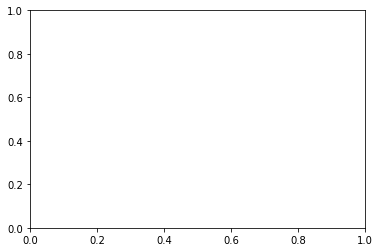

In [9]:
# Estimate camera response function (CRF)
cal_debevec = cv.createCalibrateDebevec()
crf_debevec = cal_debevec.process(img_list, times=exposure_times)
hdr_debevec = merge_debevec.process(img_list, times=exposure_times.copy(), response=crf_debevec.copy())

cal_robertson = cv.createCalibrateRobertson()
crf_robertson = cal_robertson.process(img_list, times=exposure_times)
hdr_robertson = merge_robertson.process(img_list, times=exposure_times.copy(), response=crf_robertson.copy())
x = np.arange(0, 256, 1)
color = ('b','g','r')
for i,col in enumerate(color):
    
    plt.plot(x, crf_debevec[i], color = col)
    plt.xlim([0, 256])
plt.show()


#### Additional Resources
1. Paul E Debevec and Jitendra Malik. Recovering high dynamic range radiance maps from photographs. In ACM SIGGRAPH 2008 classes, page 31. ACM, 2008. [43]
2. Mark A Robertson, Sean Borman, and Robert L Stevenson. Dynamic range improvement through multiple exposures. In Image Processing, 1999. ICIP 99. Proceedings. 1999 International Conference on, volume 3, pages 159–163. IEEE, 1999. [163]
3. Tom Mertens, Jan Kautz, and Frank Van Reeth. Exposure fusion. In Computer Graphics and Applications, 2007. PG'07. 15th Pacific Conference on, pages 382–390. IEEE, 2007. [133]
4. Images from Wikipedia-HDR

#### Exercises
1. Try all tonemap algorithms: [cv::TonemapDrago](https://docs.opencv.org/3.4/da/d53/classcv_1_1TonemapDrago.html), [cv::TonemapDurand](https://docs.opencv.org/3.4/da/d3d/classcv_1_1TonemapDurand.html), [cv::TonemapMantiuk](https://docs.opencv.org/3.4/de/d76/classcv_1_1TonemapMantiuk.html) and [cv::TonemapReinhard](https://docs.opencv.org/3.4/d0/dec/classcv_1_1TonemapReinhard.html)
2. Try changing the parameters in the HDR calibration and tonemap methods.